# online_retail_II

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


sns.set()

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
# from IPython.core.display import display, HTML
from IPython.display import display, HTML

display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# ----------------- 학습 ----------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# ----------------- 평가 ----------------------
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve

from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve

# Data Load

<pre>
Invoice: 송장 번호입니다. 명사 같은. 각 트랜잭션에 고유하게 할당된 6자리 정수입니다. 이 코드가 문자 'c'로 시작하면 취소를 나타냅니다.
StockCode: 제품(항목) 코드입니다. 명사 같은. 각 개별 제품에 고유하게 할당된 5자리 정수 번호입니다.
Description: 제품(항목) 이름입니다. 명사 같은.
Quantity: 거래당 각 제품(항목)의 수량입니다. 숫자.
InvoiceDate: 송장 날짜 및 시간. 숫자. 트랜잭션이 생성된 날짜와 시간입니다.
Price: 단가. 숫자. 스털링 단위의 제품 가격(£).
Customer ID: 고객 번호입니다. 명사 같은. 각 고객에게 고유하게 할당된 5자리 정수 번호입니다.
Country: 국가 이름입니다. 명사 같은. 고객이 거주하는 국가의 이름입니다.

In [3]:
df = pd.read_csv("online_retail_II.csv",parse_dates=['InvoiceDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [4]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


- Description --> 삭제  *
- Customer ID --> 결측(비회원) 삭제 *
- Country -->  United Kingdom 만 골라냄 *
- Price > 0 인 애들만 골라냄 *
- InvoiceDate-->하나의 날짜를 기준으로 몇일전에 방문했는지
- Quantity,Price  --> 얼마나 많이 주문했는가
- Customer ID, Invoice  --> 얼마나 자주 주문했는가

# Invoice

## 취소여부  : df['cancel']   --> y/n

In [5]:
df['Invoice'][df['Invoice'].str.contains('C')]

178        C489449
179        C489449
180        C489449
181        C489449
182        C489449
            ...   
1065910    C581490
1067002    C581499
1067176    C581568
1067177    C581569
1067178    C581569
Name: Invoice, Length: 19494, dtype: object

In [6]:
df['cancel']=np.where(df['Invoice'].str.contains('C'),'y','n')

In [7]:
df=df[df['cancel']=='n']

# 삭제

## Description

In [8]:
df=df.drop('Description',axis=1)

In [9]:
df=df.drop('cancel',axis=1)

## Customer ID 결측

In [10]:
idx=df[df['Customer ID'].isna()].index

In [11]:
df=df.drop(idx,axis=0)

# Country

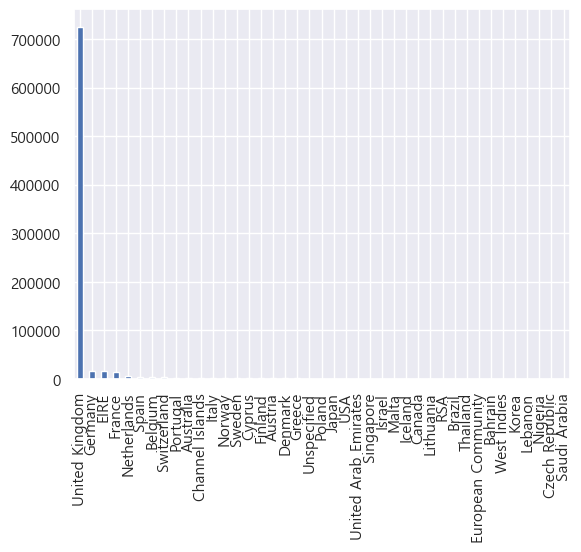

In [12]:
df['Country'].value_counts().plot(kind='bar')
plt.show()

In [13]:
df=df[df['Country']=='United Kingdom']

# Price

In [14]:
df['Price'].sort_values()

232526        0.00
16107         0.00
149202        0.00
149201        0.00
439309        0.00
            ...   
900002     3155.95
698843     8142.75
74356      8985.60
358639    10468.80
135013    10953.50
Name: Price, Length: 725296, dtype: float64

# InvoiceDate

In [15]:
max_date=df['InvoiceDate'].max()
max_date

Timestamp('2011-12-09 12:49:00')

In [16]:
df['InvoiceDate'].dt.year.value_counts()

2010    366281
2011    330402
2009     28613
Name: InvoiceDate, dtype: int64

In [17]:
df['InvoiceDate'].iloc[7000]-max_date

Timedelta('-736 days +23:47:00')

In [18]:
# for i in range(len(df)):
#     df['Last_Visit']=df['InvoiceDate'].iloc[i]-df['InvoiceDate'].max()
#     # df['Last_Visit']=df['Last_Visit'].days

In [19]:
df['InvoiceDate'].value_counts()

2011-11-14 15:27:00    542
2011-11-28 15:54:00    533
2011-12-05 17:17:00    529
2011-11-23 13:39:00    443
2011-10-31 14:09:00    435
                      ... 
2010-07-14 12:40:00      1
2011-02-17 15:40:00      1
2011-02-17 19:16:00      1
2010-07-14 10:16:00      1
2011-09-11 12:15:00      1
Name: InvoiceDate, Length: 31562, dtype: int64

In [20]:
# df['InvoiceDate'].value_counts().values

In [21]:
# df['Last_Visit'].head()

In [22]:
# df['total_pur_Quantity']=df.groupby('Customer ID')['Quantity'].transform (lambda x : x.sum())

In [23]:
df.groupby('Customer ID')['InvoiceDate'].max()-df.groupby('Customer ID')['InvoiceDate'].min()

Customer ID
12346.0   400 days 01:27:00
12608.0     0 days 00:00:00
12745.0    87 days 17:24:00
12746.0     0 days 00:00:00
12747.0   730 days 01:11:00
                 ...       
18283.0   654 days 18:46:00
18284.0     0 days 00:00:00
18285.0     0 days 00:00:00
18286.0   247 days 01:12:00
18287.0   528 days 21:34:00
Name: InvoiceDate, Length: 5353, dtype: timedelta64[ns]

# Customer ID, Invoice
- id 별 총 주문 횟수

In [25]:
df[['Customer ID', 'Invoice']].value_counts()

Customer ID  Invoice
14096.0      576339     542
             579196     533
             580727     529
             578270     442
             573576     435
                       ... 
15159.0      572064       1
             550713       1
15150.0      568415       1
15149.0      508075       1
12346.0      491725       1
Length: 33546, dtype: int64

In [26]:
df['Customer ID']=df['Customer ID'].astype('int')

In [27]:
df['Customer ID'].value_counts().index.values

array([17841, 12748, 14606, ..., 15486, 14705, 15693], dtype=int64)

In [28]:
df['total_pur_count']=df.groupby('Customer ID')['Invoice'].transform (lambda x : x.count())

# Quantity,Price

- 개당 가격

In [29]:
df['per_Price']=df['Price']/df['Quantity']

- 총 주문량, 주문 가격

In [31]:
df['total_pur_Price']=df.groupby('Customer ID')['Price'].transform (lambda x : x.sum())

In [32]:
df['total_pur_Price']=round(df['total_pur_Price'],2)

In [33]:
df['total_pur_Quantity']=df.groupby('Customer ID')['Quantity'].transform (lambda x : x.sum())

# Price/period
- 우량고객 판별

In [35]:
df['period']=df.groupby('Customer ID')['InvoiceDate'].transform(lambda x : x.max()-x.min())
df['period']=df['period'].astype('str')
df['period']=df['period'].str.extract('([0-9]+)')
df['period']=df['period'].astype('int')
df['Price/period']=df['total_pur_Price']/df['period']
df['Price/period']=np.where(df['Price/period']==np.inf,0,df['Price/period'])
df['Price/period']=round(df['Price/period'],2)

In [67]:
df['StockCode']=df['StockCode'].str.extract('([0-9]*)')

# 정리

In [44]:
df=df.drop('Country',axis=1)
df=df.drop('per_Price',axis=1)

<AxesSubplot: >

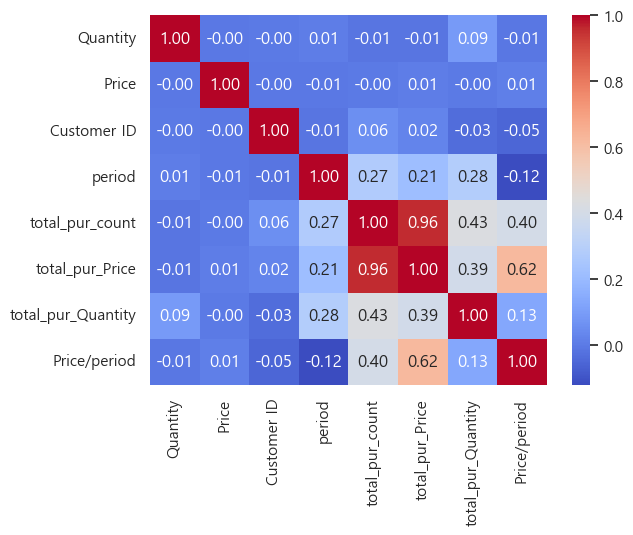

In [50]:
sns.heatmap(df.corr(), fmt=".2f", annot=True, cmap="coolwarm")

In [45]:
df.columns

Index(['Invoice', 'StockCode', 'Quantity', 'InvoiceDate', 'Price',
       'Customer ID', 'period', 'total_pur_count', 'per_Price',
       'total_pur_Price', 'total_pur_Quantity', 'Price/period'],
      dtype='object')

In [82]:
c_list=df[['Customer ID','total_pur_count', 'total_pur_Price','total_pur_Quantity', 'Price/period','period']].value_counts().index.tolist()
c_seies=np.array(c_list)
c_seies

array([[1.784100e+04, 1.289000e+04, 3.506434e+04, 3.755800e+04,
        4.771000e+01, 7.350000e+02],
       [1.274800e+04, 7.230000e+03, 2.155220e+04, 3.911000e+04,
        2.936000e+01, 7.340000e+02],
       [1.460600e+04, 6.566000e+03, 1.857584e+04, 1.563500e+04,
        2.527000e+01, 7.350000e+02],
       ...,
       [1.569300e+04, 1.000000e+00, 1.250000e+00, 3.000000e+01,
        0.000000e+00, 0.000000e+00],
       [1.504000e+04, 1.000000e+00, 7.490000e+00, 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.621900e+04, 1.000000e+00, 8.500000e-01, 4.800000e+01,
        0.000000e+00, 0.000000e+00]])

In [83]:
customer=pd.DataFrame(c_seies,columns=['Customer ID','total_pur_count', 'total_pur_Price','total_pur_Quantity', 'Price/period','period'])

In [84]:
customer

,Customer ID,total_pur_count,total_pur_Price,total_pur_Quantity,Price/period,period
0,17841.0,12890.0,35064.34,37558.0,47.71,735.0
1,12748.0,7230.0,21552.20,39110.0,29.36,734.0
2,14606.0,6566.0,18575.84,15635.0,25.27,735.0
3,14096.0,5111.0,33332.45,16352.0,343.63,97.0
4,15311.0,4434.0,11868.70,71010.0,16.08,738.0
...,...,...,...,...,...,...
5345,13535.0,1.0,8.95,10.0,0.00,0.0
5346,16953.0,1.0,2.08,10.0,0.00,0.0
5347,15693.0,1.0,1.25,30.0,0.00,0.0
5348,15040.0,1.0,7.49,1.0,0.00,0.0


<AxesSubplot: >

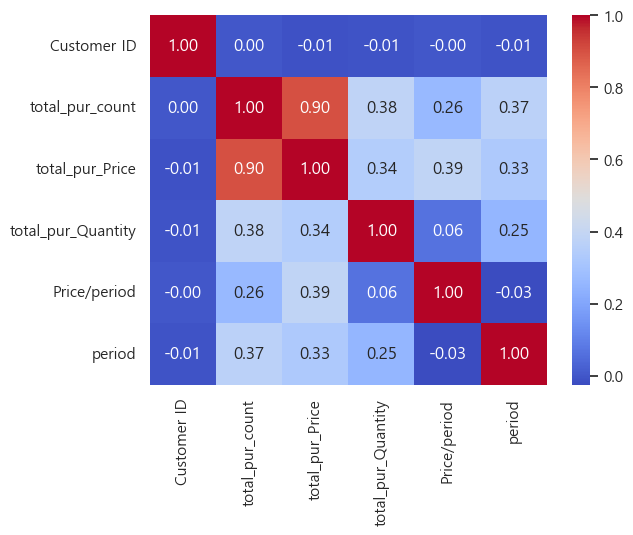

In [85]:
sns.heatmap(customer.corr(), fmt=".2f", annot=True, cmap="coolwarm")

In [87]:
from sklearn.cluster import KMeans

In [98]:
kmeans = KMeans(n_clusters=3,  random_state=11)
kmeans.fit(df[['total_pur_count', 'total_pur_Price']])    #--------- y가 없다
pred = kmeans.predict(df[['total_pur_count', 'total_pur_Price']]) 
# pred_df = pd.DataFrame({"pred_cluster_label":pred, "y":y_test})
# pred_df[['sl','sw']] = X_test[['sl','sw']]
# pred_df[pred_df["y"]==2].head()
df['pred']=pred

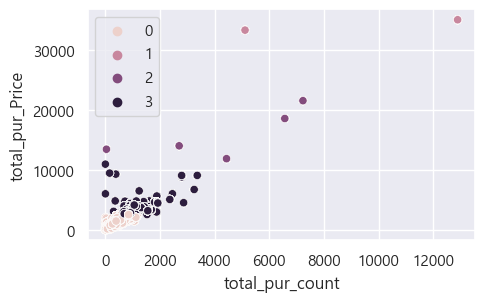

In [100]:
plt.figure(figsize=(5,3))
sns.scatterplot(x='total_pur_count', y='total_pur_Price', data=df, hue=pred)
plt.show()

In [96]:
kmeans = KMeans(n_clusters=4,  random_state=11)
kmeans.fit(customer[['total_pur_count', 'total_pur_Price']])    #--------- y가 없다
pred = kmeans.predict(customer[['total_pur_count', 'total_pur_Price']]) 
# pred_df = pd.DataFrame({"pred_cluster_label":pred, "y":y_test})
# pred_df[['sl','sw']] = X_test[['sl','sw']]
# pred_df[pred_df["y"]==2].head()
customer['pred']=pred

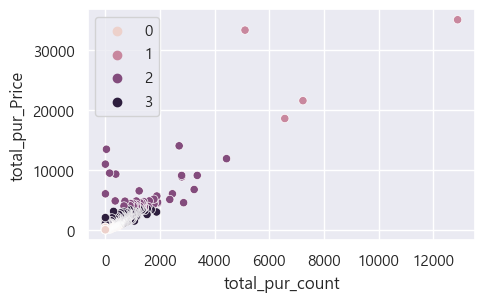

In [97]:
plt.figure(figsize=(5,3))
sns.scatterplot(x='total_pur_count', y='total_pur_Price', data=customer, hue=pred)
plt.show()